# Charging Station Exploratory Data Analysis

This notebook provides the code for importing alternative fuel station data from the US Department of Energy website, cleaning and manipulating the data to give insight on what regions have the most charging stations, creating bar charts, and creating an interactive choropleth that shows the total number of charging stations and supported levels of charging in each US county.

Import, Clean, and Maniplulate the Data

In [1]:
#Import necessary libraries
import requests
import json
import pandas as pd

In [2]:
#Pull information on electric cars into json format
parameters = {
    "format":"json",
    "api_key":"DEMO_KEY",
    "status":"all",
    "fuel_type":"ELEC"}

response = requests.get('https://developer.nrel.gov/api/alt-fuel-stations/v1.json', params=parameters).json()

data = pd.DataFrame.from_dict(response["fuel_stations"])

data.head()

,access_code,access_days_time,access_detail_code,cards_accepted,date_last_confirmed,expected_date,fuel_type_code,groups_with_access_code,id,open_date,...,ng_fill_type_code,ng_psi,ng_vehicle_class,access_days_time_fr,intersection_directions_fr,bd_blends_fr,groups_with_access_code_fr,ev_pricing_fr,ev_network_ids,federal_agency
0,private,Fleet use only,None,None,2020-09-03,None,ELEC,Private,1517,1999-10-15,...,None,None,None,None,None,None,Privé,None,NaN,NaN
1,private,Employee use only,None,None,2021-01-14,None,ELEC,TEMPORARILY UNAVAILABLE (Private),1520,None,...,None,None,None,None,None,None,TEMPORAIREMENT SUSPENDU (Privé),None,NaN,NaN
2,public,24 hours daily; pay lot,None,None,2020-11-09,None,ELEC,Public,1523,1995-08-30,...,None,None,None,None,None,None,Public,None,NaN,NaN
3,private,For fleet and employee use only,None,None,2020-11-09,None,ELEC,Private,1525,1999-10-15,...,None,None,None,None,None,None,Privé,None,NaN,NaN
4,private,Fleet use only,None,None,2020-09-03,None,ELEC,Private,1531,2018-05-01,...,None,None,None,None,None,None,Privé,None,NaN,NaN


How many charging stations, public and private, are included in this dataset? Roughly 43,504 at the time of writing this.

In [3]:
total = len(data)
print("There are currently {} electric vehicle charging stations in the United States (public and private).".format(total)) 

There are currently 43504 electric vehicle charging stations in the United States (public and private).


However, for the purpose of this exploratory data analysis, only charging stations with public access that are open 24/7 are being looked at. Charging stations have to be readily accessible to the general public at any time of the day for them to help build the case of electric vehicles being practical alternatives to traditional gas cars.

In [4]:
#Public Access Only
data = data[data['access_code'] == 'public']

#Only want chargers with 24/7 accesss... There are multiple variants listed, but they all start with "24"
data = data[data['access_days_time'].str.startswith('24', na=False)]

data.head()

,access_code,access_days_time,access_detail_code,cards_accepted,date_last_confirmed,expected_date,fuel_type_code,groups_with_access_code,id,open_date,...,ng_fill_type_code,ng_psi,ng_vehicle_class,access_days_time_fr,intersection_directions_fr,bd_blends_fr,groups_with_access_code_fr,ev_pricing_fr,ev_network_ids,federal_agency
2,public,24 hours daily; pay lot,None,None,2020-11-09,None,ELEC,Public,1523,1995-08-30,...,None,None,None,None,None,None,Public,None,NaN,NaN
10,public,24 hours daily,None,None,2021-01-14,None,ELEC,Public,1583,1996-10-15,...,None,None,None,None,None,None,Public,None,NaN,NaN
12,public,24 hours daily,None,None,2021-01-14,None,ELEC,Public,6355,1997-07-30,...,None,None,None,None,None,None,Public,None,NaN,NaN
13,public,24 hours daily,None,None,2021-01-14,None,ELEC,Public,6384,2014-09-02,...,None,None,None,None,None,None,Public,None,NaN,NaN
16,public,24 hours daily; pay lot,None,None,2020-04-08,None,ELEC,Public,6505,1997-08-30,...,None,None,None,None,None,None,Public,None,NaN,NaN


How many charging stations are there that are public and open 24/7? Roughly 33,973 at the time of writing this. (compared to 43,504 total)

In [5]:
total_accessible = len(data)
print("There are currently {} public, 24/7 EV charging stations nationwide.".format(total_accessible)) 

There are currently 33973 public, 24/7 EV charging stations nationwide.


## Analyze Data at the State and County Levels

Answering the question of whether or not the charging infrastructure exists for electric vehicle use to be practical requires looking at the data from different regional perspectives. Some states have more charging stations than other states, and the same is true for counties, so it follows that EV usage practicality differs by region.

State data will be analyzed first. (Puerto Rico is included.)

In [6]:
chargers_per_state = data.copy()
chargers_per_state = chargers_per_state.groupby('state').size().reset_index(name='counts').sort_values(by='counts', ascending=False).reset_index(drop=True)
chargers_per_state.head()

,state,counts
0,CA,11009
1,NY,2144
2,FL,1623
3,TX,1562
4,MA,1384


Let's polish up the data by referring to states by their full name.

In [7]:
states = {"AL":"Alabama","AK":"Alaska","AZ":"Arizona","AR":"Arkansas","CA":"California","CO":"Colorado","CT":"Connecticut","DE":"Delaware",\
          "FL":"Florida","GA":"Georgia","HI":"Hawaii","ID":"Idaho","IL":"Illinois","IN":"Indiana","IA":"Iowa","KS":"Kansas","KY":"Kentucky",\
          "LA":"Louisiana","ME":"Maine","MD":"Maryland","MA":"Massachusetts","MI":"Michigan","MN":"Minnesota","MS":"Mississippi","MO":"Missouri",\
          "MT":"Montana","NE":"Nebraska","NV":"Nevada","NH":"New Hampshire","NJ":"New Jersey","NM":"New Mexico","NY":"New York","NC":"North Carolina",\
          "ND":"North Dakota","OH":"Ohio","OK":"Oklahoma","OR":"Oregon","PA":"Pennsylvania","RI":"Rhode Island","SC":"South Carolina","SD":"South Dakota",\
          "TN":"Tennessee","TX":"Texas","UT":"Utah","VT":"Vermont","VA":"Virginia","WA":"Washington","WV":"West Virginia","WI":"Wisconsin","WY":"Wyoming",\
         "PR":"Puerto Rico", "DC":"District of Columbia"}

chargers_per_state['State'] = chargers_per_state.state.map(states)
chargers_per_state.head()

,state,counts,State
0,CA,11009,California
1,NY,2144,New York
2,FL,1623,Florida
3,TX,1562,Texas
4,MA,1384,Massachusetts


Altair is the library that will be used to create bar charts.

In [8]:
import altair as alt

alt.themes.enable('fivethirtyeight')

bars = alt.Chart(chargers_per_state).mark_bar(color='#80c97c').encode(
    x=alt.Y("State:N", sort='-y', title='State',
           axis=alt.Axis(labelAngle=-45, domain=False, labelColor='black')),
    y=alt.Y("counts:Q", title='Number of Charging Stations',
           axis=alt.Axis(domain=False, labelColor='black'))
)

text = bars.mark_text(
    angle=315,
    align='center',
    baseline='top',
    dx= 10,
    dy=-13  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='counts:Q'
)

(bars + text).properties(
    height=320, width=1000, 
    title={'text': 'Electric Car Charging Stations per State',
          'subtitle': 'Public & Open 24/7',
          'subtitleFontSize': 18}
    ).configure_view(strokeWidth=0)

alt.LayerChart(...)

California far outnumbers the other states in terms of public access, 24/7 charging stations, but there are several of other large coastal states with thousands of charging stations. Most of the states that are on the lower end in terms of number of charging stations are either generally more rural and less-populous, or small in terms of area.

County data will now be analyzed. However, the original dataset only contains ZIP codes, so they need to be mapped to counties. 
Zip Code and county data can be found at https://www.unitedstateszipcodes.org/zip-code-database/. A dictionary to map ZIP and county data will be made with this information.

In [9]:
#Load data
zip_county_df = pd.read_csv('assets\zip_code_database.csv')

#Create zip-county dictionary from datadrame
zip_county_df = zip_county_df[['zip','county','state']]
zip_county_df = zip_county_df.set_index('zip')
zip_dict = zip_county_df.to_dict('index')

The dictionary is used to map zip codes in the original public, 24/7 dataframe to their resepctive counties. The dataframe will be grouped by county to provide counts of charging stations in each county. Supporting charging Levels for each station will also be shown and used for later analysis.

In [10]:
chargers_per_zip = data.copy()

#Reduce columns to relevant information
chargers_per_zip = chargers_per_zip[['city','state','zip','access_code','access_days_time', 'latitude',
                                'longitude','ev_level1_evse_num','ev_level2_evse_num', 'ev_dc_fast_num']]

chargers_per_zip.zip =chargers_per_zip.zip.apply(pd.to_numeric, errors='coerce') #Need to convert zips from objects to numbers to map

#Use zip_dict to map to counties, and create a column with county and state in it
chargers_per_zip['County'] = chargers_per_zip['zip'].map(zip_dict) #Puts dictionary into county_dict column in form {'county': 'Orange County}
df = chargers_per_zip["County"].apply(pd.Series) #Create df with counties separated
chargers_per_zip = pd.concat([chargers_per_zip, df['county']], axis=1).drop('County', axis=1) #Concatenate the county names back in

#Add county and state for merging with gdf later. (Need both in same column)
chargers_per_zip['county_state'] = chargers_per_zip['county'] + ', ' + chargers_per_zip['state'] 

chargers_per_zip.head(3)

,city,state,zip,access_code,access_days_time,latitude,longitude,ev_level1_evse_num,ev_level2_evse_num,ev_dc_fast_num,county,county_state
2,Los Angeles,CA,90015.0,public,24 hours daily; pay lot,34.040539,-118.271387,NaN,12.0,NaN,Los Angeles County,"Los Angeles County, CA"
10,El Monte,CA,91731.0,public,24 hours daily,34.068720,-118.064000,NaN,3.0,NaN,Los Angeles County,"Los Angeles County, CA"
12,La Jolla,CA,92037.0,public,24 hours daily,32.899470,-117.243000,NaN,1.0,NaN,San Diego County,"San Diego County, CA"


In [11]:
#Group By county_state and aggregate counts (Cities will be summed arbitrarily for total counts)
chargers_per_county = chargers_per_zip.groupby('county_state').agg({'city': 'size', 'ev_level1_evse_num': 'count',\
                                                                'ev_level2_evse_num':'count','ev_dc_fast_num':'count'}).\
                                                                    reset_index().sort_values(by='city', ascending=False).reset_index(drop=True)

#Fix Columns
chargers_per_county.columns = ['county_state','counts','ev_level1_evse_num','ev_level2_evse_num', 'ev_dc_fast_num']

chargers_per_county.head()

,county_state,counts,ev_level1_evse_num,ev_level2_evse_num,ev_dc_fast_num
0,"Los Angeles County, CA",2699,6,2532,207
1,"Santa Clara County, CA",1330,6,1264,83
2,"Orange County, CA",1253,9,1146,130
3,"San Mateo County, CA",835,4,778,64
4,"San Diego County, CA",755,0,707,66


Use a bar chart to visualize the 30 counties with the most charging stations.

In [12]:
alt.themes.enable('fivethirtyeight')

bars = alt.Chart(chargers_per_county[:30]).mark_bar(color='#80c97c').encode(
    x=alt.Y("county_state:N", sort='-y', title='Location',
           axis=alt.Axis(labelAngle=-45, domain=False, labelColor='black')),
    y=alt.Y("counts:Q", title='Number of Charging Stations',
           axis=alt.Axis(domain=False, labelColor='black'))
)

text = bars.mark_text(
    angle=315,
    align='center',
    baseline='top',
    dx= 10,
    dy=-13  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='counts:Q'
)

(bars + text).properties(
    height=320, width=1000, 
    title={'text': '30 Counties with the Most Electric Car Charging Stations',
          'subtitle': 'Public & Open 24/7',
          'subtitleFontSize': 18}
    ).configure_view(strokeWidth=0)

alt.LayerChart(...)

The counties with the most EV charging stations are predominantly located in California, with other urban centers appearing in the top 30.

## Interactive Choropleth of Electric Vehicle Charging Stations by County

A choropleth will be created to show the number of charging stations in each US county, and a tooltip will be added to provide more specific information like the number of stations that support the different levels of charging. This visualization is intended to address questions concerning where EV ownership is the most practical based on charging locations and what locations could do better to support EV ownership.

The folium library will be used to create the choropleth, and geopandas will used to manipulate geographic data in the same way pandas does. 

The shape file that defines the US county boundaries can be found at the US Census Bureau's website: https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html

In [13]:
import geopandas

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

#Read in Geographic Information
gdf_county = geopandas.read_file('assets\County_Boundaries\cb_2019_us_county_20m.shp')
gdf_county.crs = "EPSG:4326" #Set CRS - I don't know why this is necessary, but it is

In [14]:
#Reduce geometric info
gdf_county_reduced = gdf_county[['geometry','STATEFP','COUNTYFP','NAME']]
gdf_county_reduced.crs = "EPSG:4326" #Set CRS

#Combine STATEFP and COUNTYFP to map to full State, County Name
gdf_county_reduced['STCOUNTYFP'] = gdf_county_reduced['STATEFP'] + gdf_county_reduced['COUNTYFP']
gdf_county_reduced['STCOUNTYFP'] = gdf_county_reduced['STCOUNTYFP'].astype(int)

gdf_county_reduced.head()

,geometry,STATEFP,COUNTYFP,NAME,STCOUNTYFP
0,"POLYGON ((-94.63203 40.57176, -94.53388 40.570...",29,227,Worth,29227
1,"POLYGON ((-99.17940 40.35068, -98.72683 40.350...",31,061,Franklin,31061
2,"POLYGON ((-79.76195 42.26986, -79.62748 42.324...",36,013,Chautauqua,36013
3,"POLYGON ((-78.49773 36.51467, -78.45728 36.541...",37,181,Vance,37181
4,"POLYGON ((-88.94916 36.41010, -88.81642 36.410...",47,183,Weakley,47183


Polygons are now defined for eacy county boundary, but they somehow need to be translated to the county and state names. 
The data from https://www.kaggle.com/danofer/zipcodes-county-fips-crosswalk?select=ZIP-COUNTY-FIPS_2017-06.csv can be used to map the 'STCOUNTYFP' codes to county names. Afterwards, the data can be merged with the charging station data.

In [15]:
code_dict_df= pd.read_csv('assets/ZIP-COUNTY-FIPS_2017-06.csv')

#Needs to drop duplicates
code_dict_df = code_dict_df.drop_duplicates(subset=['STCOUNTYFP'],keep='first')
#Drop ZIP and CLASSFP columns
code_dict_df = code_dict_df[['COUNTYNAME','STATE','STCOUNTYFP']]
                                     
code_dict_df.head(3)

,COUNTYNAME,STATE,STCOUNTYFP
0,Autauga County,AL,1001
13,Baldwin County,AL,1003
41,Barbour County,AL,1005


In [16]:
#Merge with geo data
gdf_county_mapped = gdf_county_reduced.merge(code_dict_df, how='outer', on='STCOUNTYFP')

#Combine state and county names into same column for merging (Notice how the county and state names were also combined in chargers_per_county)
gdf_county_mapped['county_state'] = gdf_county_mapped['COUNTYNAME'] + ', ' + gdf_county_mapped['STATE'] 

gdf_county_mapped.head()

,geometry,STATEFP,COUNTYFP,NAME,STCOUNTYFP,COUNTYNAME,STATE,county_state
0,"POLYGON ((-94.63203 40.57176, -94.53388 40.570...",29,227,Worth,29227,Worth County,MO,"Worth County, MO"
1,"POLYGON ((-99.17940 40.35068, -98.72683 40.350...",31,061,Franklin,31061,Franklin County,NE,"Franklin County, NE"
2,"POLYGON ((-79.76195 42.26986, -79.62748 42.324...",36,013,Chautauqua,36013,Chautauqua County,NY,"Chautauqua County, NY"
3,"POLYGON ((-78.49773 36.51467, -78.45728 36.541...",37,181,Vance,37181,Vance County,NC,"Vance County, NC"
4,"POLYGON ((-88.94916 36.41010, -88.81642 36.410...",47,183,Weakley,47183,Weakley County,TN,"Weakley County, TN"


Now the geographic data is to be merged with the data in chargers_per_county to tie county boundaries to the counts of chargers

In [17]:
# Merge the geometric file with the chargers_per_zip df
merged_gdf = gdf_county_mapped.merge(chargers_per_county, how='outer', on='county_state') #Playing with outer to get all geometric

merged_gdf.sort_values(by='counts', ascending=True)
merged_gdf.head()

,geometry,STATEFP,COUNTYFP,NAME,STCOUNTYFP,COUNTYNAME,STATE,county_state,counts,ev_level1_evse_num,ev_level2_evse_num,ev_dc_fast_num
0,"POLYGON ((-94.63203 40.57176, -94.53388 40.570...",29,227,Worth,29227.0,Worth County,MO,"Worth County, MO",NaN,NaN,NaN,NaN
1,"POLYGON ((-99.17940 40.35068, -98.72683 40.350...",31,061,Franklin,31061.0,Franklin County,NE,"Franklin County, NE",NaN,NaN,NaN,NaN
2,"POLYGON ((-79.76195 42.26986, -79.62748 42.324...",36,013,Chautauqua,36013.0,Chautauqua County,NY,"Chautauqua County, NY",10.0,0.0,8.0,2.0
3,"POLYGON ((-78.49773 36.51467, -78.45728 36.541...",37,181,Vance,37181.0,Vance County,NC,"Vance County, NC",4.0,0.0,2.0,2.0
4,"POLYGON ((-88.94916 36.41010, -88.81642 36.410...",47,183,Weakley,47183.0,Weakley County,TN,"Weakley County, TN",NaN,NaN,NaN,NaN


Counties that do not have charging station have to have NaN's replaced with zero to be put on the choropleth. Also, counties that don't have geometric data are removed.

In [18]:
#Eliminate rows with no geometry
merged_gdf = merged_gdf[merged_gdf['geometry'].notna()]

#Fill null values with 0 (Have to do this after removing irrelevant null geometries)
merged_gdf = merged_gdf.fillna(0)

merged_gdf.head()

,geometry,STATEFP,COUNTYFP,NAME,STCOUNTYFP,COUNTYNAME,STATE,county_state,counts,ev_level1_evse_num,ev_level2_evse_num,ev_dc_fast_num
0,"POLYGON ((-94.63203 40.57176, -94.53388 40.570...",29,227,Worth,29227.0,Worth County,MO,"Worth County, MO",0.0,0.0,0.0,0.0
1,"POLYGON ((-99.17940 40.35068, -98.72683 40.350...",31,061,Franklin,31061.0,Franklin County,NE,"Franklin County, NE",0.0,0.0,0.0,0.0
2,"POLYGON ((-79.76195 42.26986, -79.62748 42.324...",36,013,Chautauqua,36013.0,Chautauqua County,NY,"Chautauqua County, NY",10.0,0.0,8.0,2.0
3,"POLYGON ((-78.49773 36.51467, -78.45728 36.541...",37,181,Vance,37181.0,Vance County,NC,"Vance County, NC",4.0,0.0,2.0,2.0
4,"POLYGON ((-88.94916 36.41010, -88.81642 36.410...",47,183,Weakley,47183.0,Weakley County,TN,"Weakley County, TN",0.0,0.0,0.0,0.0


Before creating the choropleth, HTML code is used to create a draggable and more readable legend.

The original template code for the legend was created by Colin Talbert at https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd, and it has been modified for the purpose of this project.

In [19]:
from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Charging</div>
<div class='legend-title'>Stations</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#ffffcc;opacity:0.8;'></span>0</li>
    <li><span style='background:#c2e699;opacity:0.8;'></span>1 - 2</li>
    <li><span style='background:#78c679;opacity:0.8;'></span>3 - 11</li>
    <li><span style='background:#31a354;opacity:0.8;'></span>12 - 65</li>
    <li><span style='background:#006837;opacity:0.8;'></span>66 - 2699</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

Use folium to create a choropleth, and add a tooltip for information related to supported charging levels. 

In [20]:
import folium

m = folium.Map([39.8283, -98.5795], zoom_start=4)

#Mapbox Bright
folium.TileLayer(tiles='CartoDB positron',control=True, opacity=0.0).add_to(m) #Baseline
    
myscale = [0, 1, 3, 12, 66, merged_gdf.counts.max()]

colors = ['#d1eca0', '#9ed688', '#62bb6e', '#329750', '#0e723b']

choropleth = folium.Choropleth(
    geo_data=merged_gdf,
    data=merged_gdf,
    columns=["county_state", "counts"],
    key_on="feature.properties.county_state",
    fill_color = 'YlGn',
    threshold_scale=myscale,
    fill_opacity =  1,
    line_color='white',
    line_weight = .2,
    line_opacity=.6,
    name="Charging Stations",
    show=True,
    legend_name = 'Charging Stations in County',
    highlight = True,
    smooth_factor = .2
).add_to(m)

macro = MacroElement()
macro._template = Template(template)

m.get_root().add_child(macro)

folium.LayerControl(collapsed=True).add_to(m)

choropleth.geojson.add_child(folium.features.GeoJsonTooltip(
        fields=['COUNTYNAME', 'STATE', 'counts', 'ev_level1_evse_num', 'ev_level2_evse_num', 'ev_dc_fast_num'],
        aliases=['County:     ', 'State:     ', 'Charging Stations:     ',\
                'Number of Stations w/ Lvl. 1 Charging:     ',
                'Number of Stations w/ Lvl. 2 Charging:     ',\
                'Number of Stations w/ DC Fast Charging:     '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
        localize=True
        )
)

#Delete Default color scale (It overlaps)
for key in choropleth._children:
    if key.startswith('color_map'):
        del(choropleth._children[key])
        
#Display the map and save
m.save(outfile= "us_chargingstations_county.html")

from IPython.display import IFrame

IFrame(src='us_chargingstations_county.html', width=850, height=450)

The choropleth provides a top-down overview of which regions have the most (or least) charging stations. The regions that are shaded a darker green and have relatively more charging stations are the entiere West Coast, Florida, New England, Michigan, and other urban centers. Practicality of Electric Vehicles ultimately comes down to which county an EV user resides in and what their driving habits are like. Hence, the map can somewhat be used as a tool to gage whether or not a particular has enough charging stations for an individual's needs. More specifically, one can use the map to see if there are enough charging stations that support a certain level of charging.

## Case Study: Texas

An interesting case study for the adoption of electric vehicle charging stations is Texas. With 1,562 charging stations, the state ranks 4th in the country for number of 24/7, public charging stations. However, the chasm between the cities with the most and least chargers is quite large. The top 5 cities hold 952 out of Texas' 1,562 public, 24/7 charging stations. Also of note is that 150 out of Texas' 254 counties don't have a single public, 24/7 charging station. The more densely populated areas have the infrastructure to make the lives of EV owners easier, but the more rural areas have catching up to do in terms of practicality.

In [21]:
# Reduce data to Texas data only
texas_df = data.copy()
texas_df = texas_df[texas_df.state=='TX']
num_texas = len(texas_df)
print("Texas has {} public, 24/7 charging stations.".format(num_texas))

Texas has 1562 public, 24/7 charging stations.


In [22]:
#Group by city, arbitrarily sum up the ID
texas_cities = texas_df.groupby('city').size().reset_index(name='counts').sort_values(by='counts', ascending=False).reset_index(drop=True)

In [23]:
#How many Texas *counties* don't have charging stations

tx_counties = merged_gdf[merged_gdf.STATE=='TX']
num_tx_counties = len(tx_counties)
tx_counties_0 = tx_counties[tx_counties.counts==0]
empty_tx = len(tx_counties_0)

print("Texas has {} counties.".format(num_tx_counties))
print("Texas has {} counties with zero public, 24/7 charging stations.".format(empty_tx))

Texas has 254 counties.
Texas has 150 counties with zero public, 24/7 charging stations.


In [24]:
#Visualize counts for top 20 cities

import altair as alt

alt.themes.enable('fivethirtyeight')

bars = alt.Chart(texas_cities[:20]).mark_bar(color='#80c97c').encode(
    y=alt.Y("city:N", sort='-x', title='City',
           axis=alt.Axis(labelAngle=0, domain=False, labelColor='black')),
    x=alt.X("counts:Q", title='Number of Charging Stations',
           axis=alt.Axis(domain=False, labelColor='black'))
)

text = bars.mark_text(
    angle=0,
    align='center',
    baseline='middle',
    dx= 10,
    dy=0  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='counts:Q'
)

(bars + text).properties(
    height=320, width=1000, 
    title={'text': '20 Cities in Texas with the Most Electric Car Charging Stations',
          'subtitle': 'Out of 1,562 Public & 24/7 Charging Stations',
          'subtitleFontSize': 18}
    ).configure_view(strokeWidth=0)

alt.LayerChart(...)

## What are the Different Levels of Charging, and What Percent of Charging Stations Support Each?

There are three different levels of charging: Level 1, Level 2, and Level 3. ( DC Fast Charging) Level 1 is convenient in that anyone with a wall outlet can charge their EV; however, it is slow. Level 2 is available for both residential and commercial applications and charges an EV with 10-20 miles of range per hour. Level 3 is the fastest by far, giving 180-240 miles of range per hour, but it is only available commercially. A charging station that supports higher levels of charging can be said to be more convenient ot EV drivers.

In [25]:
#The original dataset has to be looked at again to inspect each individual charging station that's 24/7 and public.
c_type = data.copy()

How many public, 24/7 charging stations nationwide support Level 1 charging? Roughly 627 at the time of writing this. This makes sense, considering that level one charging is meant for ordinary wall sockets and only gives you 2-5 miles of range/hr.

In [26]:
num_level1 = c_type['ev_level1_evse_num'].count() #Count function doesn't consider NaNs
print("There are currently {} public, 24/7 EV charging stations that support Level 1 charging.".format(num_level1)) 

There are currently 627 public, 24/7 EV charging stations that support Level 1 charging.


How many public, 24/7 charging stations nationwide support Level 2 charging? Roughly 30,089 at the time of writing this. While it may not be more convenient than DC fast charging, level 2 is older technology and is supported by more adapters.

In [27]:
num_level2 = c_type['ev_level2_evse_num'].count() #Count function doesn't consider NaNs
print("There are currently {} public, 24/7 EV charging stations that support Level 2 charging.".format(num_level2)) 

There are currently 30122 public, 24/7 EV charging stations that support Level 2 charging.


How many public, 24/7 charging stations support Level 3 charging? Roughly 4,264 at the time of writing this. It is the most convenient for EV drivers, but it is more recent technology, and it will take time to see more widespread adoption.

In [28]:
num_level3 = c_type['ev_dc_fast_num'].count() #Count function doesn't consider NaNs
print("There are currently {} public, 24/7 EV charging stations that support Level 3 fast charging.".format(num_level3)) 

There are currently 4264 public, 24/7 EV charging stations that support Level 3 fast charging.


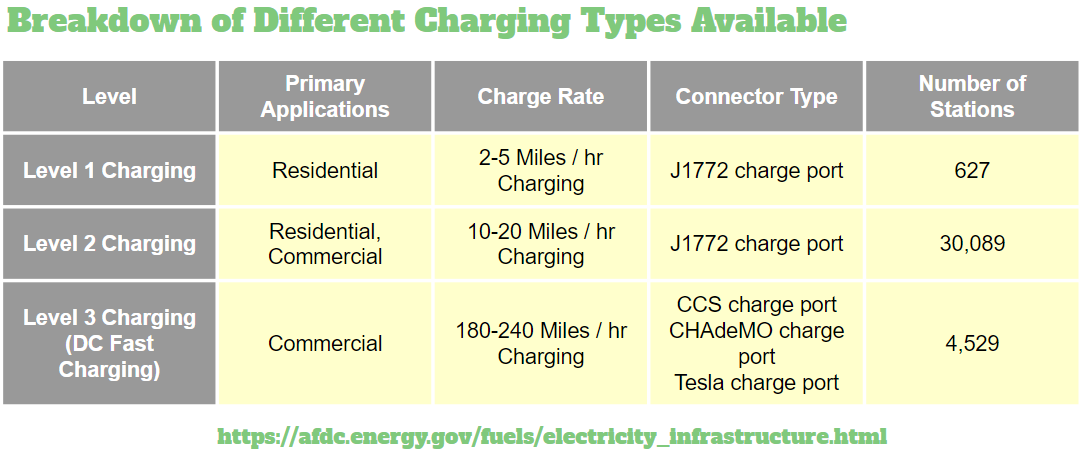

In [29]:
#Construct Dataframe with information on Chargers
diff_chargers_df= pd.DataFrame({
    'Level' : ['Level 1 Charging','Level 2 Charging','Level 3 Fast Charging'],
    'Primary Applications' : ['Residential','Residental & Commercial','Commercial'],
    'Charge Rate (Miles/hr)' :  ['2 - 5','10 - 20','180 - 240'],
    'Charge Ports' : ['J1772','J1772','CCS, CHAdeMO, & Tesla'],
    'Number of Supporting Stations' :  [num_level1, num_level2, num_level3]
                                })
#Calculate percent of supporting stations and format
diff_chargers_df['Percent of Supporting Stations'] = \
        (diff_chargers_df['Number of Supporting Stations'] / len(c_type) * 100).round(1).astype(float)
diff_chargers_df.Level = diff_chargers_df.Level.astype(str)
diff_chargers_df

,Level,Primary Applications,Charge Rate (Miles/hr),Charge Ports,Number of Supporting Stations,Percent of Supporting Stations
0,Level 1 Charging,Residential,2 - 5,J1772,627,1.8
1,Level 2 Charging,Residental & Commercial,10 - 20,J1772,30122,88.7
2,Level 3 Fast Charging,Commercial,180 - 240,"CCS, CHAdeMO, & Tesla",4264,12.6


In [30]:
bars = alt.Chart(diff_chargers_df).mark_bar(size=33, color='#80c97c').encode(
    x=alt.X(
        'Percent of Supporting Stations:Q',
        axis=None),
    y=alt.Y(
        # encode y using the name, use the movie name to label the axis, sort using the names_l
        'Level:N', sort='-x',
         axis=alt.Axis(ticks=False, title='')
    )
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    # we'll use the percentage as the text
    text=alt.Text('Percent of Supporting Stations:Q')
)

# finally, we're going to combine the bars and the text and do some styling
percent = (text + bars).configure_mark(
).configure_view(
    # we don't want a stroke around the bars
    strokeWidth=0
).configure_scale(
    # add some padding
    bandPaddingInner=0.1
).properties(
    width=400,
    height=120
).properties(
    # add a title
    title={
      "text": ["Percent of Supporting Charging Stations for each Level of Charging"], 
      "subtitle": 'Of 33,935 Public Access, 24/7 Charging Stations Nationwide ',
      "subtitleFontSize": 16,
      'fontSize': 20
    }
).configure_axis(
    labelFontSize=16,
    labelColor='black',
    labelPadding=15,
)

percent

alt.LayerChart(...)